# Implementation of [Complex Networks Classification with Convolutional Neural Network](https://arxiv.org/pdf/1802.00539.pdf)

In [245]:
import networkx as nx
from karateclub import DeepWalk
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decomposition import PCA
import numpy as np
import io
import cv2
from tqdm import tqdm

In [2]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size':13})

### Converting graph into image

1. Create graph embedding (using e.g. DeepWalk)
2. Use PCA to reduce the dimension of node representation into 2-d space
3. Rasterize the 2-d scatter plot into 48x48 grid. **In my implementation: convert matplotlib.plot into image and then create numpy array as input to the CNNs**
4. Count the number of nodes in each grid as the pixel grayscale
5. Input to CNN :)

![pipeline](pipeline.png)

In [54]:
def draw_network(g: nx.Graph, scale_size=True, node_size=40, edge_alpha=0.3):
    plt.figure(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(g)
    if scale_size:
        d = [node_size * size for size in dict(g.degree).values()]
    else:
        d = [node_size] * len(g)
    nx.draw_networkx(g, pos=pos, with_labels=False, node_size=1, alpha=0)
    nx.draw_networkx_edges(g, pos=pos, alpha=edge_alpha)
    nx.draw_networkx_nodes(g, pos=pos, node_size=d, node_color='darkorange', edgecolors='black')
    plt.axis('off')

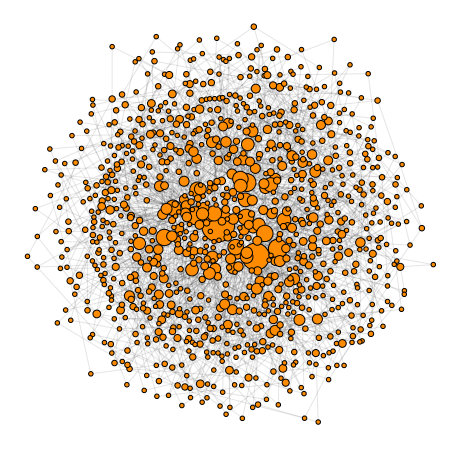

In [256]:
ba = nx.barabasi_albert_graph(1000, m=2)
draw_network(ba, node_size=10, edge_alpha=0.1)

In [265]:
def deep_walk(g, walk_number=10, walk_length=80, dimensions=128):
    model = DeepWalk(walk_number=walk_number, walk_length=walk_length, dimensions=dimensions)
    model.fit(g)
    return model.get_embedding()


def get_pca_components(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(embeddings)
    return pca.components_


def draw_embeddings(pca_components):
    plt.scatter(pca_components[0, :], pca_components[1, :])
    plt.title("2D embeddings of network")
    
    
def get_img_from_fig(fig, dpi=180, new_size=(100, 100)):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, new_size)
    return img


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def get_image_from_embeddings(pca_components, input_size=(100, 100)):
    """
    Based on: https://stackoverflow.com/a/58641662/9511702
    """
    fig = plt.figure(figsize=(6, 6))
    fig.tight_layout(pad=0)
    plt.scatter(pca_components[0, :], pca_components[1, :], alpha=0.3)
    plt.axis('off')
    plt.xticks([], [])
    image = get_img_from_fig(fig, new_size=input_size)
    image_greyscale = rgb2gray(image)
    image_greyscale = np.reshape(image_greyscale, newshape=(image_greyscale.shape[0], image_greyscale.shape[1], 1))
    plt.close()
    return image_greyscale


def plot_network_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image[:, :, 0], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [258]:
a = get_pca_components(deep_walk(ba).T)

In [259]:
a.shape

(2, 1000)

In [266]:
res = get_image_from_embeddings(a)

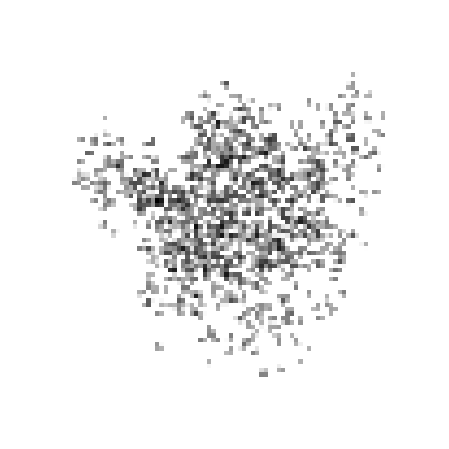

In [267]:
plot_network_image(res)

In [252]:
def create_synthetic_input(size, k, network_type='BA', input_size=(100, 100)):
    if network_type == 'BA':
        network = nx.barabasi_albert_graph(size, m=(int)(k / 2))
    elif network_type == 'ER':
        network = nx.fast_gnp_random_graph(size, p=k/size)
    else:
        print('Wrong network type. Available `BA`, `ER`.')
    
    embedding = get_pca_components(deep_walk(network).T)
    return network_type, get_image_from_embeddings(embedding, input_size)

In [253]:
N = 100
k = 6

ba_networks = []
er_networks = []


for n in tqdm(range(100)):
    ba = create_synthetic_input(N, k)
    er = create_synthetic_input(N, k, network_type='ER')
    
    ba_networks.append(ba)
    er_networks.append(er)


  0%|                                                                 | 0/100 [00:00<?, ?it/s]

(100, 100)
(100, 100)



  1%|▌                                                        | 1/100 [00:01<01:52,  1.13s/it]

(100, 100)
(100, 100)



  2%|█▏                                                       | 2/100 [00:02<01:50,  1.13s/it]

(100, 100)


ValueError: Graph is not connected. Please see requirements.

In [268]:
# TODO - graph must be connected, fix Erdos-Reneyi graphs 